# Modeling Peak Bloom Dates with Cropbox

[Cropbox](https://github.com/tomyun/Cropbox.jl) is a modeling framework for developing crop models. It greatly simplifies various technical implementations required for modeling, allowing users to focus on the model itself, rather than the underlying code. We will look at various phenological models to get a better grasp of how one can utilize Cropbox as a modeling framework. Specifically, we will look at various models that utilize meteorological and phenological data to predict peak bloom dates. More information regarding the peak bloom models we will use is available through [Yun *et al.*](https://doi.org/10.1016/j.ecolmodel.2017.08.003).

In [2]:
using Cropbox
using CSV
using DataFrames
using Dates
using TimeZones
using Statistics

WebIO._IJuliaInit()

Before we begin, we will load various packages we require using the `using` syntax from Julia.

## Dataset

In order to calibrate the peak bloom models that we will look at, we require two datasets: daily average temperature and yearly peak bloom date.

### Meteorological Data

In this example, we will use the daily average temperature data from Washington, D.C.

For some locations, it is possible that the average temperature data is incomplete or unavailable. In such cases, we can also substitute the average temperature with the midrange temperature. Naturally, this may result in different parameters for our calibrations, and the model evaluations may vary.

Below, we load the CSV file of temperature data as a `DataFrame` using the [CSV.jl](https://github.com/JuliaData/CSV.jl) package.

`unitfy()` is a Cropbox function for convenience that allows automatic detection of the units of the data based on the column name of the CSV file.

The operator `|>` is used to send the output of the `CSV.read()` function directly to the `unitfy()` function.

In [3]:
meteorological = CSV.read("dc_weather.csv", DataFrame) |> unitfy

,date,Tavg,Tmin,Tmax
,Date,Quantity…,Quantity…,Quantity…
1,1936-09-01,25.2 °C,15.7 °C,29.6 °C
2,1936-09-02,22.2 °C,19.1 °C,25.2 °C
3,1936-09-03,22.2 °C,19.1 °C,25.2 °C
4,1936-09-04,22.5 °C,16.3 °C,28.0 °C
5,1936-09-05,21.8 °C,13.5 °C,26.8 °C
6,1936-09-06,21.5 °C,15.2 °C,25.7 °C
7,1936-09-07,23.8 °C,16.9 °C,30.2 °C
8,1936-09-08,27.3 °C,20.7 °C,32.9 °C
9,1936-09-09,28.7 °C,22.4 °C,33.5 °C


We can also visualize a graph of the data using the `visualize()` function. Note the order of the parameters of the function. The `kind` option allows us to choose how we want to display data points. By default, it is `:scatter`.

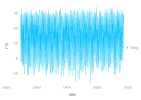

In [6]:
visualize(meteorological, :date, [:Tavg]; kind = :line)

### Phenological Data

Similarly, for our phenological data, we will use the yearly peak bloom dates of cherry blossoms in Washington, D.C.

In [8]:
phenological = CSV.read("cherry_dc_obs.csv", DataFrame) |> unitfy

,year,doy
,Int64,Quantity…
1,1921,79 d
2,1922,97 d
3,1923,99 d
4,1924,104 d
5,1925,86 d
6,1926,101 d
7,1927,79 d
8,1928,99 d
9,1929,90 d


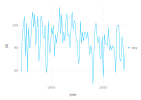

In [9]:
visualize(phenological, :year, :doy; kind = :line)

## Model

We will use the `@system` syntax to create individual systems for each of our models. `@system` is a Cropbox macro that allows us to a create a unique `System` containing a number of variables. When a `System` is defined, the structure of the system cannot be changed in any manner, meaning that no variables can be added or removed. However, the state of the variables can be updated. The contents of the system are defined in the body of code between `begin` and `end`.

`Temperature` is a system containing necessary time and temperature variables that will be used throughout our models. While `Temperature` itself is not one of our models, it is a system that will be used for the systems that represent our peak bloom models. Within the `Temperature` system, `Calendar` itself is a system that contains the variables `time` and `step` in the form of `ZonedDateTime`. It is a necessary system if we want to use the time variable in the calendar date format. The system also includes variable declaration for date and temperature data using `provide` and `drive`. Syntax such as `drive` followed by `~` are state verbs that specify the kind of the variables. For example, the `track` verb makes it so that the variable is recalculated at every time step. `drive` creates a driving variable from a specified data source, with the data source often being a dataframe supplied through the use of `provide`.

In [11]:
@system Temperature begin
    calendar(context)      ~ ::Calendar
    t(calendar.date): date ~ track::date
    data                   ~ provide(parameter, index = :date, init = t)
    T:         temperature ~ drive(from = data, by = :Tavg, u"°C")
end

Temperature

### Forcing-Only Models

While the nature of these models will become more clear when we also look at the chilling-forcing models, forcing-only models at the core are models in which the peak bloom date is determined by the accumulation of warm temperatures.

#### Growing Degrees (GD)

Growing degree (GD) is often used to predict the growth of plants in the growing season. Each day, based on the average temperature data, the degrees above a certain temperature threshold (growing degrees per day) is updated and accumulated at every time step using `track` and `accumulate`. When the accumulation of the growing degree days reaches a certain threshold, we assume that peak bloom has been achieved. `preserve` is a verb for preserving the initial value of a variable, and is therefore often used for constants and parameters.

The `flag` variable is similar to `track` in a sense, but with `Bool` (true or false) values. In the GD system below, `match` is a flag variable that will either be true or false, based on the specified logical operator `cGGD >= Rd`. Similarly, `stop` is a flag variable that essentially checks whether a match has been found or the last day of the calendar has been reached.

In [12]:
@system GD(Temperature, Controller) begin
    Tb: base_temperature    ~ preserve(parameter, u"°C")
    To: optimal_temperature ~ preserve(parameter, u"°C")
    Rd: accumulation_requirement ~ preserve(parameter, u"K")
    
    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    Δt: timestep => 1                                ~ preserve(u"d")
    GD(T, Tb, To): growing_degree => min(T, To) - Tb ~ track(min = 0, u"K")
    GDD(GD, Δt): growing_degree_day => GD / Δt       ~ track(u"K/d")
    cGDD(GDD): cumulative_growing_degree_day         ~ accumulate(u"K")
    
    match(cGDD, Rd)                       => (cGDD >= Rd) ~ flag
    stop(m = match, s = calendar.stop) => (m || s)  ~ flag
end

GD

#### Sigmoid Function (SF)

In the previous model, the 'growth' of the plant, i.e. the progression to full bloom, is assumed to have a linear relationship to temperature accumulation. In the sigmoid version of the model, we assume that this relationship is non-linear, and we add a new parameter `St` for temperature sensitivity. As we can see in the system below, a new `track` variable `ΔT` is used for accumulation instead of the `GDD` used in the GD model.

In [ ]:
@system SF(Temperature, Controller) begin
    Tb: base_temperature    ~ preserve(parameter, u"°C")
    To: optimal_temperature ~ preserve(parameter, u"°C")
    St: temperature_sensitivity ~ preserve(parameter, u"K^-1")
    Rd: accumulation_requirement ~ preserve(parameter)
    
    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    Δt: timestep => 1                                ~ preserve(u"d")
    ΔT(T, Tb, To, St): rate => begin
        1 / (1 + ℯ^(St*(min(T, To) - Tb))) 
    end ~ track(u"d^-1")
    D(ΔT): accumulation                              ~ accumulate
    
    match(D, Rd)                       => (D >= Rd) ~ flag
    stop(m = match, s = calendar.stop) => (m || s)  ~ flag
end

#### Beta Function (BF)

The beta function version of the model reflects the curve of the beta distribution where the bloom progression rate gradually increases as temperature increases, but declines rapidly at much higher temperatures. In the BF model, the peak bloom date is determined by the accumulation of the `track` variable `r`. The `flag` variable `valid` makes sure that the inequality remains true, which was necessary for proper `r` calculation.

In [ ]:
@system BF(Temperature, Controller) begin
    Tn: minimum_temperature => 0 ~ preserve(parameter, u"°C")
    To: optimal_temperature      ~ preserve(parameter, u"°C")
    Tc: ceiling_temperature      ~ preserve(parameter, u"°C")
    Rx: maximum_rate        => 1 ~ preserve(parameter, u"d^-1")
    Rd: accumulation_requirement ~ preserve(parameter)
    
    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")
    
    Ta(T) ~ track(min = Tn, u"°C")
    
    Δt: timestep => 1                                                                                           ~ preserve(u"d")
    r(Ta, Tn, To, Tc, Rx): rate => Rx * (Tc - Ta) / (Tc - To) * ((Ta - Tn) / (To - Tn))^((To - Tn) / (Tc - To)) ~ track(min = 0, max = Rx, u"d^-1")
    R(r): cumulative_rate ~ accumulate
    
    valid(Tn, Tc, To)                  => (Tn <= To <= Tc) ~ flag
    match(R, Rd, valid)                => ((R >= Rd) && valid) ~ flag
    stop(m = match, s = calendar.stop, valid) => ((m || s) || !valid) ~ flag
end

#### Days Transferred to Standard Temperature (DTS)

The DTS model is a modification of the Arrehenius equation. The Arrehenius equation is an equation describing the effect of temperature on the velocity of a chemical equation. This modification is a result of the basis that phenological changes too are driven by chemical reactions

In [ ]:
@system DTS(Temperature, Controller) begin
    Ts: standard_temperature     ~ preserve(parameter, u"°C")
    Ea: temperature_sensitivity  ~ preserve(parameter, u"kJ/mol")
    Rd: accumulation_requirement ~ preserve(parameter)

    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    R:       gas_constant                  => u"R" ~ preserve(u"J/K/mol")
    Tk(T):   absolute_temperature                  ~ track(u"K")
    Tsk(Ts): absolute_standard_temperature         ~ track(u"K")

    Δt:                     timestep     => 1                                           ~ preserve(u"d")
    ΔT(Tk, Tsk, Ea, R, Δt): rate         => (ℯ^(Ea * (Tk - Tsk) / (R * Tk * Tsk)) / Δt) ~ track(u"d^-1")
    D(ΔT):                  accumulation                                                ~ accumulate

    match(D, Rd)                       => (D >= Rd) ~ flag
    stop(m = match, s = calendar.stop) => (m || s)  ~ flag
end

#### Thermal Period Fixed Model (TP)

The thermal period fixed model is essentially identical to the GD model, but with the assumption that forcing is accumulated over a fixed time period.

In [ ]:
@system TP(Temperature, Controller) begin
    Tb: base_temperature    ~ preserve(parameter, u"°C")
    To: optimal_temperature ~ preserve(parameter, u"°C")
    Rd: accumulation_requirement ~ preserve(parameter, u"K")
    Dn: day_threshold ~ preserve(parameter, u"d")
    
    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    Δt: timestep => 1                                ~ preserve(u"d")
    GD(T, Tb, To): growing_degree => min(T, To) - Tb ~ track(min = 0, u"K")
    GDD(GD, Δt): growing_degree_day => GD / Δt       ~ track(u"K/d")
    cGDD(GDD): cumulative_growing_degree_day         ~ accumulate(u"K")
    
    match(cGDD, Rd)                    => (cGDD >= Rd) ~ flag
    stop(m = match, s = calendar.stop, Dn, doy) => ((m || s) || (doy >= Dn))  ~ flag
end

### Two-Step Models

#### Chilling and Forcing (CF)

The two-step models are fundamentally different from the forcing models because a process termed chilling is added. Much like forcing is an accumulation of temperature-dependent measures above a certain threshold, chilling represents accumulation below the threshold.

In the CF model, the accumulation of temperature per day below a certain threshold is measured until a chilling requirement is met, at which point forcing begins and growing degrees are accumulated until it reaches the full bloom threshold. This is represented by addition of the `flag` variable `d`. The variable `F` is only accumulated when the `flag` variable `d` is `True`.

In [ ]:
@system CF(Temperature, Controller) begin
    Tc: temperature_threshold ~ preserve(parameter, u"°C")
    Rc: chilling_requirement  ~ preserve(parameter, u"K")
    Rf: forcing_requirement   ~ preserve(parameter, u"K")

    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    Ta(T)                                    ~ track(min = 0, u"°C")
    Δt(context.clock.step)                   ~ preserve(u"d")
    ΔT(Ta, Tc, Δt)         => (Ta - Tc) / Δt ~ track(u"K/d")

    c(ΔT): chilling             ~ track(max = 0, u"K/d")
    C(c):  chilling_accumulated ~ accumulate(when = !d, u"K")

    d(C, Rc):    chilling_done => (C <= Rc) ~ flag

    f(ΔT): forcing              ~ track(min = 0, u"K/d")
    F(f):  forcing_accumulated  ~ accumulate(when = d, u"K")

    match(F, Rf)                       => (F >= Rf) ~ flag
    stop(m = match, s = calendar.stop) => (m || s)  ~ flag
end

#### Sequential Model (SM)

In the CF model, the chilling and forcing accumulations were essentially accumulation of degree days. In the sequential model, the chilling portion of the model was replaced with a triangular response function, while the forcing portion of the model used a sigmoid function, much like the SF model. Other than the inclusion of several parameters for the chilling and forcing functions, the overall structure remains the same as the CF model.

In [ ]:
@system SM(Temperature, Controller) begin
    Tn: minimum_temperature => 0 ~ preserve(parameter, u"°C")
    To: optimal_temperature      ~ preserve(parameter, u"°C")
    Tc: ceiling_temperature      ~ preserve(parameter, u"°C")
    Rx: maximum_rate        => 1 ~ preserve(parameter, u"d^-1")
    Rc: chilling_requirement  ~ preserve(parameter)
    Tb: base_temperature    ~ preserve(parameter, u"°C")
    Rf: forcing_requirement   ~ preserve(parameter)
    St: temperature_sensitivity ~ preserve(parameter, u"K^-1")
    
    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    Ta(T)                                    ~ track(min = 0, u"°C")
    Δt(context.clock.step)                   ~ preserve(u"d")
    ΔT(Ta, Tn, To, Tc, Rx): rate => Rx * (Tc - Ta) / (Tc - To) * ((Ta - Tn) / (To - Tn))^((To - Tn) / (Tc - To)) ~ track(min = 0, max = Rx, u"d^-1")

    c(ΔT): chilling             ~ track(max = 0, u"d^-1")
    C(c):  chilling_accumulated ~ accumulate(when = !d)

    d(C, Rc): chilling_done => (C <= Rc) ~ flag

    f(Ta, Tb, To, St): forcing => 1 / (1 + exp(St*(min(Ta, To) - Tb))) ~ track(min = 0)
    F(f):  forcing_accumulated  ~ accumulate(when = d)

    match(F, Rf)                       => (F >= Rf) ~ flag
    stop(m = match, s = calendar.stop) => (m || s)  ~ flag
end

#### Parallel Model

In contrast to both the CF and SM, the parallel model, as the name implies, is a model where chilling and forcing can occur simultaneously. However, the forcing portion is weighted by the accumulation of chilling. As a result, during earlier dates, forcing would accumulate slowly even during unusually warm days. However, this also means that forcing requirement can still be met even under unsually warm weathers resulting in slow chilling accumulation.

In [ ]:
@system PM(Temperature, Controller) begin
    Tn: minimum_temperature => 0 ~ preserve(parameter, u"°C")
    To: optimal_temperature      ~ preserve(parameter, u"°C")
    Tc: ceiling_temperature      ~ preserve(parameter, u"°C")
    Rx: maximum_rate        => 1 ~ preserve(parameter, u"d^-1")
    Rc: chilling_requirement     ~ preserve(parameter)
    Tb: base_temperature         ~ preserve(parameter, u"°C")
    Rf: forcing_requirement      ~ preserve(parameter)
    St: temperature_sensitivity  ~ preserve(parameter, u"K^-1")
    Km: forcing_weight ~ preserve(parameter)
    
    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    Ta(T)                                    ~ track(min = 0, u"°C")
    Δt(context.clock.step)                   ~ preserve(u"d")
    ΔT(Ta, Tn, To, Tc, Rx): rate => Rx * (Tc - Ta) / (Tc - To) * ((Ta - Tn) / (To - Tn))^((To - Tn) / (Tc - To)) ~ track(min = 0, max = Rx, u"d^-1")

    c(ΔT): chilling             ~ track(max = 0, u"d^-1")
    C(c):  chilling_accumulated ~ accumulate

    kh(Km, C, Rc): forcing_degree => Km + (1 - Km) * C / Rc ~ track

    f(kh, Ta, Tb, To, St): forcing => kh / (1 + exp(St*(min(Ta, To) - Tb))) ~ track(min = 0)
    F(f):  forcing_accumulated  ~ accumulate

    match(F, Rf)                       => (F >= Rf) ~ flag
    stop(m = match, s = calendar.stop) => (m || s)  ~ flag
end

## Configuration

Similar to how we created a `System` using the `@system` syntax, we can create configurations for our models using the `@config` syntax.

The following is a configuration for the intial and final dates for `:Calendar`, the time steps for `:Clock`, and the meterological data for `:Temperature`. The initial date of October 1st is a somewhat arbitrary estimate when the process begins, and is related to a general timeline of when senescence occurs. Similarly, the last date of May 31st is an arbitrary date that is unlikely to have a significant impact because most full bloom events occur before May 31st.

In [13]:
date_config(year) = @config (
    :Calendar => (;
        init = ZonedDateTime(year-1, 10,  1, tz"UTC"),
        last = ZonedDateTime(year,    5, 31, tz"UTC"),
    ),
    :Clock => (;
        step = 1u"d",
    ),
    :Temperature => (;
        data = meteorological,
    ),
)

date_config (generic function with 1 method)

## Estimation

For ease of use, we will create `estimate()` functions which will essentially run the `simulate()` functions in a more specific manner. The `estimate()` function will simulate the day-to-day phenological changes for the specified years using the specified model configuration.

The `callback()` function provides an arbitary result for cases where the full bloom requirement is never met by the model. This is necessary in case the estimation yields no results.

In [ ]:
callback(s, m) = if s.stop' && !s.match'
    m.result[end, :doy] = 365u"d"
end

In [ ]:
estimate(S, years;
    config,
    index = :year,
    target = :doy,
    stop = :stop,
    kw...
) = simulate(S;
    configs = @config(config + date_config.(years)),
    index,
    target,
    stop,
    snap = stop,
    callback,
    kw...
)

The `estimate2` is a function for estimating the full bloom dates of specified years by calculating the average peak bloom date for all the models based on their specified configurations.

In [ ]:
estimate2(Ss, years; configs, target = :doy, kw...) = begin
    Es = [estimate(S, years; config, target, kw...) for (S, config) in zip(Ss, configs)]
    key = Cropbox.parsetarget(target, nothing) |> only |> first
    M = mean([getproperty(E, key) for E in Es])
    DataFrame([:year => years, key => unitfy(round.(Int, deunitfy(M, u"d")), u"d")])
end

## Calibration

The following are configurations for each model containing  their parameters values calibrated using the `calibrate()` method.

`calibrate()` is a Cropbox function that optimizes a system's set of parameters within a given range. Specifically, the parameters are optimized using global optimization methods from the Julia package [BlackBoxOptim.jl](https://github.com/robertfeldt/BlackBoxOptim.jl). Because the function can only optimize parameters based on the range specified by a user, it is important to understand what the parameters represent, especially when they have biological significance. Similarly, we can also specify the number of steps taken for optimization. This is also important because we want to avoid both underfitting and overfitting the model to the observations.

In [ ]:
GD_config = calibrate(GD, phenological;
    configs = @config(date_config.(2000:2010)),
    index = :year,
    target = :doy,
    parameters = :GD => (;
        Tb = (0, 40),
        To = (0, 40),
        Rd = (0, 300)
    ),
    stop = :stop,
    snap = :stop,
    callback,
    optim = (;
        MaxSteps = 10000,
    ),
)

In [ ]:
SF_config = calibrate(SF, phenological;
    configs = @config(date_config.(2011:2021)),
    index = :year,
    target = :doy,
    parameters = :SF => (;
        Tb = (-10, 50),
        To = (-10, 30),
        Rd = (0, 1000),
        St = (0, 100),
    ),
    stop = :stop,
    snap = :stop,
    callback,
    optim = (;
        MaxSteps = 10000,
    ),
)

In [ ]:
BF_config = calibrate(BF, phenological;
    configs = @config(date_config.(2011:2021)),
    index = :year,
    target = :doy,
    parameters = :BF => (;
        To = (0, 30),
        Tc = (0, 30),
        Rd = (0, 1000),
    ),
    stop = :stop,
    snap = :stop,
    callback,
    optim = (;
        MaxSteps = 10000,
    ),
)

In [ ]:
DTS_config = calibrate(DTS, phenological;
    configs = @config(date_config.(2011:2021)),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (-10, 30),
        Ea = (0, 200),
        Rd = (0, 500),
    ),
    stop = :stop,
    snap = :stop,
    callback,
    optim = (;
        MaxSteps = 10000,
    ),
)

In [ ]:
TP_config = calibrate(TP, phenological;
    configs = @config(date_config.(2011:2021)),
    index = :year,
    target = :doy,
    parameters = :TP => (;
        Tb = (0, 50),
        To = (0, 50),
        Rd = (0, 1000),
        Dn = (100, 365)
    ),
    stop = :stop,
    snap = :stop,
    callback,
    optim = (;
        MaxSteps = 10000,
    ),
)

In [ ]:
CF_config = calibrate(CF, phenological;
    configs = @config(date_config.(2000:2010)),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (0, 10),
        Rc = (-300, 0),
        Rf = (0, 300),
    ),
    stop = :stop,
    snap = :stop,
    callback,
    optim = (;
        MaxSteps = 10000,
    ),
)

In [ ]:
SM_config = calibrate(SM, phenological;
    configs = @config(date_config.(2011:2021)),
    index = :year,
    target = :doy,
    parameters = :SM => (;
        To = (0, 30),
        Tc = (3, 8),
        Rc = (-300, 0),
        Rf = (0, 300),
        Tb = (0, 30),
        St = (0, 100)
    ),
    stop = :stop,
    snap = :stop,
    callback,
    optim = (;
        MaxSteps = 10000,
    ),
)

In [ ]:
PM_config = calibrate(PM, phenological;
    configs = @config(date_config.(2011:2021)),
    index = :year,
    target = :doy,
    parameters = :PM => (;
        To = (0, 30),
        Tc = (3, 8),
        Rc = (-300, 0),
        Rf = (0, 300),
        Tb = (0, 30),
        St = (0, 100),
        Km = (0, 1)
    ),
    stop = :stop,
    snap = :stop,
    callback,
    optim = (;
        MaxSteps = 10000,
    ),
)

## Evaluation

Once we have calibrated the models and have the configurations with the parameters, we can evaluate how well the model performs against the empirical data using Cropbox's `evaluate()` function.

For convenience, we create the `assess()` function, which evaluates the outcomes of the `estimate()` functions against the original data, and outputs the value for the specified evaluation metric.

In [ ]:
assess(S, obs, years; config, kw...) = begin
    est = estimate(S, years; config)
    evaluate(obs, est; index = :year, target = :doy, kw...)
end

The `assess2` function is essentially identical to `assess`, but evaluates the ensemble (average) of all the models.

In [ ]:
assess2(Ss, obs, years; configs, kw...) = begin
    est = estimate2(Ss, years; configs)
    evaluate(obs, est; index = :year, target = :doy, kw...)
end

We can run the code below to obtain the RMSE ans EF of each model.

In [ ]:
rmse = assess(GD, phenological, 2011:2021;
    config = GD_config,
    metric = :rmse,
)

ef = assess(GD, phenological, 2011:2021;
    config = GD_config,
    metric = :ef,
    
println("RMSE: " * string(rmse))
println("EF: " * string(ef))

In [ ]:
rmse = assess(GD, phenological, 2011:2021;
    config = GD_config,
    metric = :rmse,
)

ef = assess(GD, phenological, 2011:2021;
    config = GD_config,
    metric = :ef,
    
println("RMSE: " * string(rmse))
println("EF: " * string(ef))

In [ ]:
rmse = assess(BF, phenological, 2011:2021;
    config = BF_config,
    metric = :rmse,
)

ef = assess(BF, phenological, 2011:2021;
    config = BF_config,
    metric = :ef,
    
println("RMSE: " * string(rmse))
println("EF: " * string(ef))

In [ ]:
rmse = assess(SF, phenological, 2011:2021;
    config = GM_config,
    metric = :rmse,
)

ef = assess(SF, phenological, 2011:2021;
    config = GM_config,
    metric = :ef,
    
println("RMSE: " * string(rmse))
println("EF: " * string(ef))

In [ ]:
rmse = assess(DTS, phenological, 2011:2021;
    config = DTS_config,
    metric = :rmse,
)

ef = assess(DTS, phenological, 2011:2021;
    config = DTS_config,
    metric = :ef,
    
println("RMSE: " * string(rmse))
println("EF: " * string(ef))

In [ ]:
rmse = assess(PM, phenological, 2011:2021;
    config = PM_config,
    metric = :rmse,
)

ef = assess(PM, phenological, 2011:2021;
    config = PM_config,
    metric = :ef,
    
println("RMSE: " * string(rmse))
println("EF: " * string(ef))

In [ ]:
rmse = assess(PM, phenological, 2011:2021;
    config = PM_config,
    metric = :rmse,
)

ef = assess(PM, phenological, 2011:2021;
    config = PM_config,
    metric = :ef,
    
println("RMSE: " * string(rmse))
println("EF: " * string(ef))

## Comparison

Here we compare the actual peak bloom dates and the predicted peak bloom dates using the calibrated model configurations.

For simplicity, we create the `compare()` and `compare2()` functions, which produce graphical visualizations for comparing the original data against `estimate` and `estimate2`, respectively.

In [ ]:
compare(S, obs, years; config, kw...) = begin
    E = estimate(S, years; config)
    O = obs[obs.year .∈ Ref(years), :]
    p = visualize(O, :year, :doy; name = "Obs", kind = :scatterline, kw...)
    visualize!(p, E, :year, :doy; name = "Model", kind = :scatterline)
end

In [ ]:
compare2(Ss, obs, years; configs, kw...) = begin
    E = estimate2(Ss, years; configs)
    O = obs[obs.year .∈ Ref(years), :]
    p = visualize(O, :year, :doy; name = "Obs", kind = :scatterline, kw...)
    visualize!(p, E, :year, :doy; name = "Model", kind = :scatterline)
end

In [14]:
compare(GD, phenological, 2011:2021;
    config = GD_config,
    ylim = (80, 110),
)

LoadError: UndefVarError: GD_config not defined

In [ ]:
compare2([GD, CF, DTS], phenological, 2011:2021;
    configs = [GD_config, CF_config, DTS_config],
    ylim = (50, 110),
)